In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score as DBI

In [3]:
data1 = np.loadtxt("D31.txt")
data2 = np.loadtxt("R15.txt")
data3 = np.loadtxt("Aggregation.txt")
data3

array([[15.55, 28.65],
       [14.9 , 27.55],
       [14.45, 28.35],
       ...,
       [ 8.5 ,  3.25],
       [ 8.1 ,  3.55],
       [ 8.15,  4.  ]])

In [69]:
class DPC():
    def __init__(self, data = None):
        self.data = data
        
    # 计算数据点两两之间的距离
    def getDistanceMatrix(self, data = None):
        if(data != None):
            self.data = data
        N, D = np.shape(self.data)
        dists = np.zeros([N, N])

        for i in range(N):
            for j in range(N):
                vi = self.data[i, :]
                vj = self.data[j, :]
                dists[i, j] = np.sqrt(np.dot((vi - vj), (vi - vj)))
        self.dists = dists
        return dists
    
    # 找到密度计算的阈值dc
    # 要求平均每个点周围距离小于dc的点的数目占总点数的1%-2%
    def select_dc(self):
        '''算法1'''
        N = np.shape(self.dists)[0]
        tt = np.reshape(self.dists, N * N)
        percent = 2.0
        position = int(N * (N - 1) * percent / 100)
        dc = np.sort(tt)[position + N]
        self.dc = dc
        return dc
    
    # 计算每个点的局部密度
    def get_density(self, method=None):
        N = np.shape(self.dists)[0]
        rho = np.zeros(N)
    
        for i in range(N):
            if method == None:
                rho[i] = np.where(self.dists[i, :] < self.dc)[0].shape[0] - 1
            else:
                rho[i] = np.sum(np.exp(-(self.dists[i, :] / self.dc) ** 2)) - 1
        
        self.rho = rho
        return rho
    
    # 计算每个数据点的密度距离
    # 即对每个点，找到密度比它大的所有点
    # 再在这些点中找到距离其最近的点的距离
    def get_deltas(self):
        N = np.shape(self.dists)[0]
        deltas = np.zeros(N)
        nearest_neiber = np.zeros(N)
        # 将密度从大到小排序
        index_rho = np.argsort(-self.rho)
        for i, index in enumerate(index_rho):
            # 对于密度最大的点
            if i == 0:
                continue

            # 对于其他的点
            # 找到密度比其大的点的序号    
            index_higher_rho = index_rho[:i]
            # 获取这些点距离当前点的距离,并找最小值
            deltas[index] = np.min(self.dists[index, index_higher_rho])

            # 保存最近邻点的编号
            index_nn = np.argmin(self.dists[index, index_higher_rho])
            nearest_neiber[index] = index_higher_rho[index_nn].astype(int)

        deltas[index_rho[0]] = np.max(deltas)
        
        self.deltas = deltas
        self.nearest_neiber = nearest_neiber
        
        return deltas, nearest_neiber
    
    # 通过阈值选取 rho与delta都大的点
    # 作为聚类中心    
    def find_centers_auto(self):
        rho_threshold = (np.min(self.rho) + np.max(self.rho)) / 2
        delta_threshold = (np.min(self.deltas) + np.max(self.deltas)) / 2
        N = np.shape(self.rho)[0]

        centers = []
        for i in range(N):
            if self.rho[i] >= rho_threshold and self.deltas[i] > delta_threshold:
                centers.append(i)
                
        self.centers = np.array(centers)
        return np.array(centers)
    
    # 选取 rho与delta乘积较大的点作为
    # 聚类中心   
    def find_centers_K(self, K):
        rho_delta = self.rho * self.deltas
        centers = np.argsort(-rho_delta)
        
        self.centers = centers[:K]
        return centers[:K]
    
    def cluster_PD(self):
        K = np.shape(self.centers)[0]
        if K == 0:
            print("can not find self.")
            return
    
        N = np.shape(self.rho)[0]
        labs = -1 * np.ones(N).astype(int)
    
        # 首先对几个聚类中进行标号
        for i, center in enumerate(self.centers):
            labs[center] = i
    
        # 将密度从大到小排序
        index_rho = np.argsort(-self.rho)
        for i, index in enumerate(index_rho):
            # 从密度大的点进行标号
            if labs[index] == -1:
                # 如果没有被标记过
                # 那么聚类标号与距离其最近且密度比其大
                # 的点的标号相同
                labs[index] = labs[int(self.nearest_neiber[index])]
                
        self.labs = labs
        return labs
    
    
    # DPC算法拟合
    def fit(self, method="Gaussion", findtype = 1, K=1): # 指定1为find_centers_auto，2为find_centers_K（需要自己输入K）
        
        # 距离矩阵
        dists = self.getDistanceMatrix()
        dc = self.select_dc()
        # 计算局部密度
        rho = self.get_density(method = method)
        # 计算密度距离
        deltas, nearest_neiber = self.get_deltas()
        # 获取聚类中心点
        if findtype == 1:
            centers = self.find_centers_auto()
        elif findtype == 2:
            centers = self.find_centers_K(K = K)
        labs = self.cluster_PD()
        
        return labs
        
    
    def draw_cluster(self, dic_colors, name="cluster.pdf"):
        plt.cla()
        K = np.shape(self.centers)[0]
    
        for k in range(K):
            sub_index = np.where(self.labs == k)
            sub_datas = self.data[sub_index]
            # 画数据点
            plt.scatter(sub_datas[:, 0], sub_datas[:, 1], s=16., color=dic_colors[k])
            # 画聚类中心
            plt.scatter(self.data[self.centers[k], 0], self.data[self.centers[k], 1], color="k", marker="+", s=200.)
        plt.savefig(name)
        plt.show()
    
    

In [70]:
model1 = DPC(data=data1)
model2 = DPC(data=data2)
model3 = DPC(data=data3)

In [11]:
dis1 = model1.getDistanceMatrix()
dis1.shape

(3100, 3100)

In [71]:
label1 = model1.fit()

In [72]:
# label2 = model2.fit(method=None) # 四个聚类
# label2 = model2.fit() # 10个聚类，还行
label2 = model2.fit(findtype = 2, K=14) # 根据图像手动指定了14个

In [87]:
# label3 = model3.fit() # 高斯4个聚类
# label3 = model3.fit(method=None) # 5个聚类
label3 = model3.fit(findtype = 2, K=7) # 根据图像手动指定了7个

In [88]:
DBI(data1,label1), DBI(data2,label2), DBI(data3,label3)

(0.781987832988031, 0.37374794009855516, 0.5035680502991704)

In [83]:
n1 = model1.centers.shape[0]
n2= model2.centers.shape[0]
n3 = model3.centers.shape[0]
n1, n2, n3

(6, 14, 7)

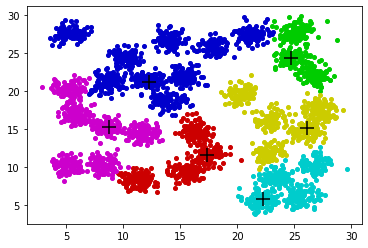

In [39]:
# Define colormap

colors1 = { 0: (.8, 0, 0), 1: (0, .8, 0),
            2: (0, 0, .8), 3: (.8, .8, 0),
            4: (.8, 0, .8), 5: (0, .8, .8),
            6: (.8, .8, .8)}

model1.draw_cluster(colors1, name = "cluster1.pdf")

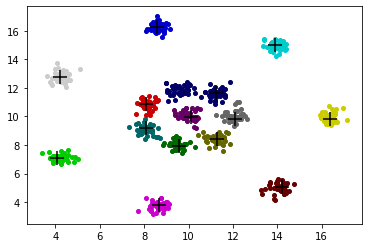

In [60]:
# Define colormap

colors2 = {  0: (.8, 0, 0), 1: (0, .8, 0),
                2: (0, 0, .8), 3: (.8, .8, 0),
                4: (.8, 0, .8), 5: (0, .8, .8),
                6: (.8, .8, .8), 7: (.4, 0, 0),
                8: (0, .4, 0), 9: (0, 0, .4),
                10:(.4, .4, 0), 11: (.4, 0, .4),
                12:(0, .4, .4), 13:(.4, .4, .4)}

model2.draw_cluster(colors2, name = "cluster2.pdf")

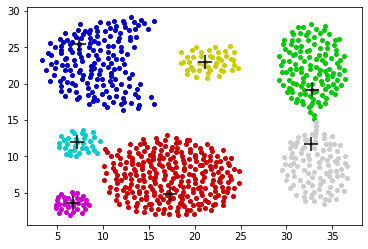

In [84]:
# Define colormap

colors3 = {  0: (.8, 0, 0), 1: (0, .8, 0),
                2: (0, 0, .8), 3: (.8, .8, 0),
                4: (.8, 0, .8), 5: (0, .8, .8),
                6: (.8, .8, .8), 7: (.4, 0, 0),
                8: (0, .4, 0), 9: (0, 0, .4),
                10:(.4, .4, 0), 11: (.4, 0, .4),
                12:(0, .4, .4), 13:(.4, .4, .4)}

model3.draw_cluster(colors3, name = "cluster3.pdf")